In [17]:
# Imports
import numpy as np
import pandas as pd
from numpy.linalg import svd, norm
import matplotlib.pyplot as plt
# add a progress bar, reorder metrics
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import time
from sklearn.preprocessing import MinMaxScaler
import warnings
%matplotlib inline

In [2]:
# Read the Data
def load_data(filepath='./data.xlsx'):
    """
        Loads tha data into pandas DataFrame format
    """
    try:
        data = pd.ExcelFile(filepath)
    except FileNotFoundError:
        print("Change Directory the file was not found!\n")

    x_train = np.asarray(data.parse("azip", header=None))
    y_train = np.asarray(data.parse("dzip", header=None))

    x_test = np.asarray(data.parse("testzip", header=None))
    y_test = np.asarray(data.parse("dtest", header=None))


    return (x_train,y_train), (x_test,y_test)

In [15]:
# Normalize the Data
def group_normalize(data_train, data_test):
    """
        Normalize in -1 to 1 scale all input_data
    """
    scaler_obj = MinMaxScaler(feature_range=(-1.0,1.0))
    data_train = scaler_obj.fit_transform(data_train.T)
    data_test = scaler_obj.transform(data_test.T)
    assert data_train.shape == data_train.shape
    assert data_test.shape == data_test.shape
    return data_train.T, data_test.T

In [23]:
# ── Create the MATLAB helper script Ima2.m ──

m_code = """function Ima2(vec)
% Ima2  Display a 16x16 digit image stored as a 256x1 column vector
%   Usage: Ima2(x) where x is 256x1

    img = reshape(vec, 16, 16)';   % reshape and transpose
    imagesc(img);                  % scaled image display
    colormap(gray);                % use grayscale
    axis image off;                % square pixels, no axes ticks
end
"""

# open with utf-8 encoding to avoid UnicodeEncodeError
with open('Ima2.m', 'w', encoding='utf-8') as f:
    f.write(m_code)

print("Created file Ima2.m in working directory")

✅ Created file Ima2.m in working directory


In [3]:
# Scaling and Plot of an Image
def scale_and_plot(img_array, real_label=None):
    """
        Scales Image to 0-20 range 
        and plots it
    """
    # If we provide Vector instead of an image, reshape it.
    if img_array.shape != (16,16):
        img_array = img_array.reshape((16,16))
    
    img_min = img_array.min()
    img_array = img_array.astype('float32')
    img_array = img_array - img_min         
    img_max = img_array.max()
    img_array = img_array * 20.0 / img_max  


    # Now the image is scaled let's plot it
    plt.figure(figsize=(8,8))
    if real_label is not None:
        plt.title(f"Real Label: {real_label}")
    plt.imshow(img_array, cmap='gray')
    plt.savefig('snp.png')
    plt.show()
    plt.close()
    return

In [4]:
# Group images by digit label
def group_digits(data_matrix, labels):
    """
        Returns a dict mapping digit→(256×n) array of images.
    """
    lbl = labels.flatten()
    return {
      digit: data_matrix[:, lbl == digit]
      for digit in np.unique(lbl)
    }

In [5]:
# Group Same Class SVD Components
def group_class_svd(class_groups):
    class_components = {}
    for class_id in class_groups.keys():
        matrix = class_groups[class_id]
        u,s,vh = svd(matrix)
        class_components.update({class_id:{'u':u,'s':s,'v':vh.T}})
    return class_components

In [6]:
# Residual‐based classifier
def classify_by_residual(vec, components, k):
    """
        Compute residual ∥x−UUᵀx∥/∥x∥ for each class and pick the smallest.
    """
    base_norm = norm(vec, 2)
    resids = []
    for lbl, comp in components.items():
        U = comp['u'][:, :k]
        proj = U @ (U.T @ vec)
        resids.append(norm(vec - proj, 2) / base_norm)
    return int(np.argmin(resids))

In [7]:
# Two-Step Algorithm
def two_step_classify(img_array, class_groups, tol):
    # Create a residual array of length equal to possible classes
    residual_array = np.empty(len(class_groups.keys()))

    # For every class calculate the relative residual error with 1 signular value
    for class_id in class_groups.keys():
        U = class_groups[class_id]['u']
        U = U[:,0:1]
        nominator = norm((np.eye(256) - U@U.T)@img_array, ord=2)
        denominator = norm(img_array, ord=2)
        residual_array[int(class_id)] = nominator / denominator
    
    # Check relative magnitude of smallest residual to second smallest residual
    si = np.argsort(residual_array) ## Sorted Indices
    residual_array = residual_array[si[:-1]] ## Sorted Array

    # If relative distance is over tol % proceed to alorithm 1
    rd = (residual_array[1] - residual_array[0]) / residual_array[0]
    if rd < tol:
        prediction = classify_by_residual(img_array, class_groups, 18)
        flag = 0
    else:
        prediction = si[0]
        flag = 1

    return prediction, flag

In [8]:
# HeatMap Code
def heatmap(result_array, i_len=10, j_len=10, figsize=7):
    fig, ax = plt.subplots(figsize=(figsize,figsize))
    im = ax.imshow(result_array, cmap='inferno')

    # We want to show all ticks...
    ax.set_xticks(np.arange(0,i_len))
    ax.set_yticks(np.arange(0,j_len))
    # ... and label them with the respective list entries
    ax.set_xticklabels(np.arange(0,i_len))
    ax.set_yticklabels(np.arange(0,j_len))

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(j_len):
        for j in range(i_len):
            if j_len == i_len:
                if i==j:
                    color = 'k'
                else:
                    color = 'w'
            else:
                if j == 0:
                    color = 'k'
                else:
                    color = 'w'
            text = ax.text(j, i, round(result_array[i, j],2),
                        ha="center", va="center", color=color)

    if i_len == j_len:
        title = "Classification Result Matrix"
    else:
        title = "Singular Values of Digits"
    ax.set_title(title)
    fig.tight_layout()
    plt.savefig('heatmap.png')
    plt.show()
    plt.close()
    return

In [9]:
### Misclassification Analysis
def misclassification_analysis(x_t,y_t,groups):
    test_groups = group_digits(x_t,y_t)
    miss_groups = {}
    # Loop Over Digits and Find Misclassified ones
    for digit in groups.keys():
        digit_x = test_groups[digit]
        predictions = np.array([classify_by_residual(f.T, groups, k=18) for f in digit_x.T])
        misclassified = digit_x.T[np.where(predictions!=digit)[0]]
        miss_groups.update({digit:misclassified})
    
    # Present 4 missclassifications from each digit
    for digit in miss_groups.keys():
        n_mc = miss_groups[digit].shape[0]
        n_c = test_groups[digit].T.shape[0]
        rate = 100*(n_mc / n_c)
        print(f"Digit {digit} has {n_mc} misclassifications resulting in {round(rate,3)}% of misclassification rate. Here are 4 of them:\n")
        for i in range(0,4):
            scale_and_plot(np.squeeze(miss_groups[digit][i]),real_label=digit)
        print("--------------------------------------------------------------\n")

    return

In [10]:
### Explore Singular Value choice for specific digits
def singular_value_performance(x_t,y_t,groups,digit):
    test_groups = group_digits(x_t,y_t)
    moving_misclassification_rate = np.empty(18)
    exec_time = np.empty(18)
    # Loop Over Digits of Choice and Report Accuracy based on using different number of singular values 
    for n_base_vec in range(1,19):
        digit_x = test_groups[digit]
        start_time = time.time()
        predictions = np.array([classify_by_residual(f.T, groups, k=n_base_vec) for f in digit_x.T])
        end_time = (time.time() - start_time)
        exec_time[n_base_vec - 1] = end_time
        misclassified = digit_x.T[np.where(predictions!=digit)[0]]
        moving_misclassification_rate[n_base_vec-1] = 100*(misclassified.shape[0] / test_groups[digit].T.shape[0])

    ### Plot Results
    plt.figure(figsize=(10,10))
    plt.grid()
    plt.plot(np.arange(1,19), moving_misclassification_rate, 'bo--', label="Misclassification Rate")
    plt.plot(np.arange(1,19), 100 - moving_misclassification_rate, 'go--', label="Accuracy")
    plt.plot(np.arange(1,19), exec_time, 'ro--', label="Execution Time")
    plt.title(f"Accuracy of Digit {digit} vs Number of Singular Values Used")
    plt.xlabel("Number of Singular Values Used")
    plt.ylabel("Accuracy")
    plt.legend(loc=4)
    plt.savefig('svp.jpg')
    plt.show()
    return


In [11]:
### Plots Tolerance Analysis
def threshold_analysis(x_t,y_t,groups):

    tusage = []
    taccuracy = []
    tolerance = [0.1,0.2,0.3,0.4]
    for tol in tolerance:
        ### Let's See what is misclassified now
        predictions = np.empty(x_t.T.shape[0])
        usage = np.empty(x_t.T.shape[0])
        for idx, f in enumerate(x_t.T):
            p,u = two_step_classify(f.T, groups, tol=tol) 
            predictions[idx]=p
            usage[idx]=u
        real = np.squeeze(y_t)
        acc = accuracy_score(real,predictions)
        us = usage.sum() / x_t.T.shape[0]
        tusage.append(us)
        taccuracy.append(acc)

    ### Plot Results
    plt.figure(figsize=(10,10))
    plt.grid()
    plt.plot(np.array(tolerance)*100, np.array(tusage)*100, 'ro--', label="Usage of 1 singular value")
    plt.plot(np.array(tolerance)*100, np.array(taccuracy)*100, 'go--', label="Accuracy")
    plt.title(f"Accuracy and Usage of only 1 singular value vs Threshold")
    plt.xlabel("Threshold Percentage")
    plt.ylabel("Accuracy / Usage")
    plt.legend(loc=3)
    
    plt.show()
    return

In [12]:
### Explore Singular Value choice for specific digits
def singular_value_search(groups):
    # Loop Over Digits of Choice and Report Magnitute of Singular Values
    table = np.empty((10,18))
    for digit in range(0,10):
        table[digit] = groups[digit]['s'][0:18]

    heatmap(table, i_len=18, j_len=10, figsize=10)
    return

### Load and Normalize Data

In [13]:
warnings.filterwarnings(
    "ignore",
    message="Unknown extension is not supported and will be removed",
    category=UserWarning,
    module="openpyxl\\.worksheet\\._read_only"
)

In [18]:
(x_,y),(x_t,y_t) = load_data()
x, x_t = group_normalize(x_,x_t)

### Plot a random image from training set with and without scale_and_plot
***

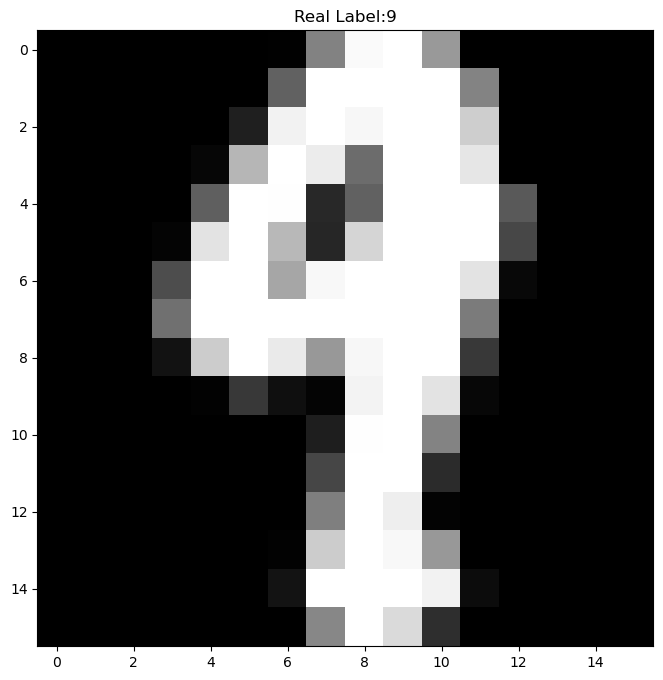

In [24]:
plt.figure(figsize=(8,8))
plt.title(f"Real Label:{y[0][123]}")
plt.imshow(x_[:,123].reshape(16,16), cmap='gray')
plt.savefig('RandomImage.png')
plt.show()
plt.close()

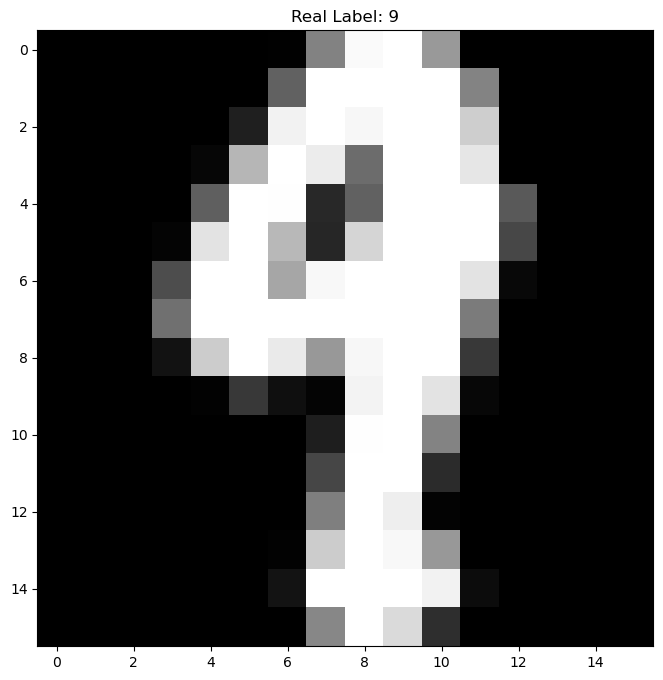

In [25]:
scale_and_plot(img_array=x_[:,123], real_label=y[0][123])

### Group Similar Digits

In [26]:
digits = group_digits(x,y)

### Group Similar Digits SVD Components

In [27]:
groups = group_class_svd(digits)

### Plot 1st 5th and 30th U components of a random digit
***

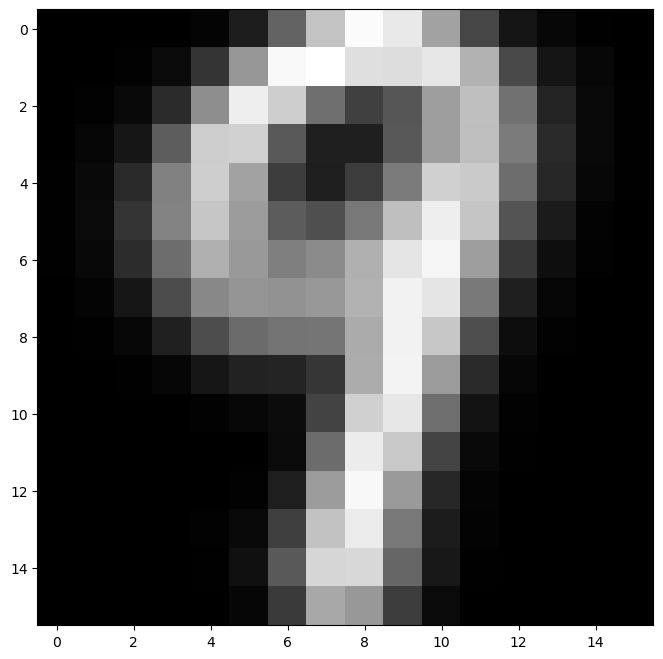

In [28]:
### Since our random 123 digit is a 9 we will use 9's U matrix
scale_and_plot(groups[9]['u'][:,0])

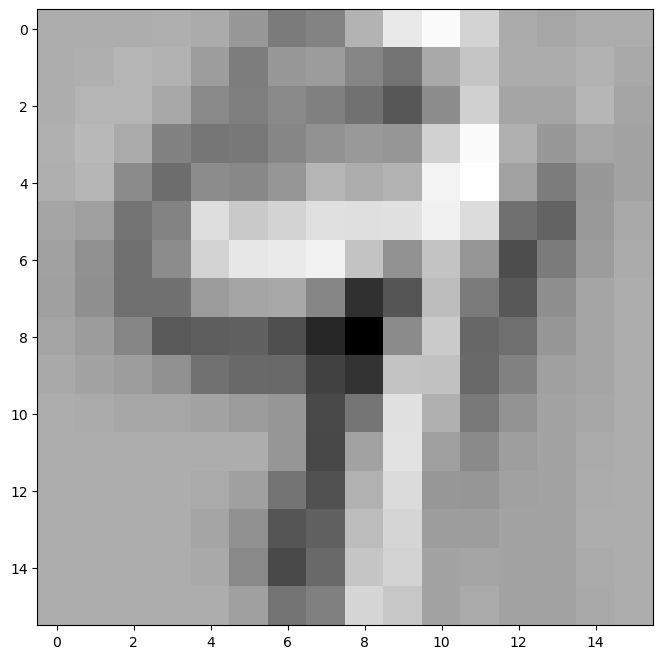

In [29]:
scale_and_plot(groups[9]['u'][:,4])

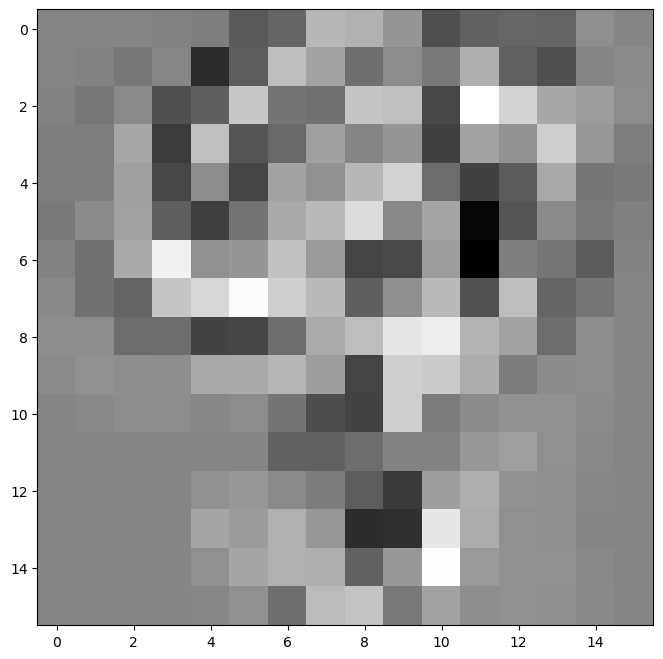

In [30]:
scale_and_plot(groups[9]['u'][:,29])

### Question 1
***

In [31]:
### Create result vector keeping accuracy and f1 scores for each number of base vectors used
accuracies = np.empty(16)
f1_scores = np.empty(16)

In [32]:
### Loop over number of base vectors and collect results
for n_base_vec in range(5, 21):
    # pass the basis‐count as the third (positional) argument
    predictions = [classify_by_residual(f.T, groups, n_base_vec) for f in x_t.T]
    acc = accuracy_score(np.squeeze(y_t), predictions)
    f1  = f1_score(np.squeeze(y_t), predictions, average='weighted')
    ### Remove the +5 offset in the indexing
    accuracies[n_base_vec - 5] = acc
    f1_scores[n_base_vec - 5]   = f1

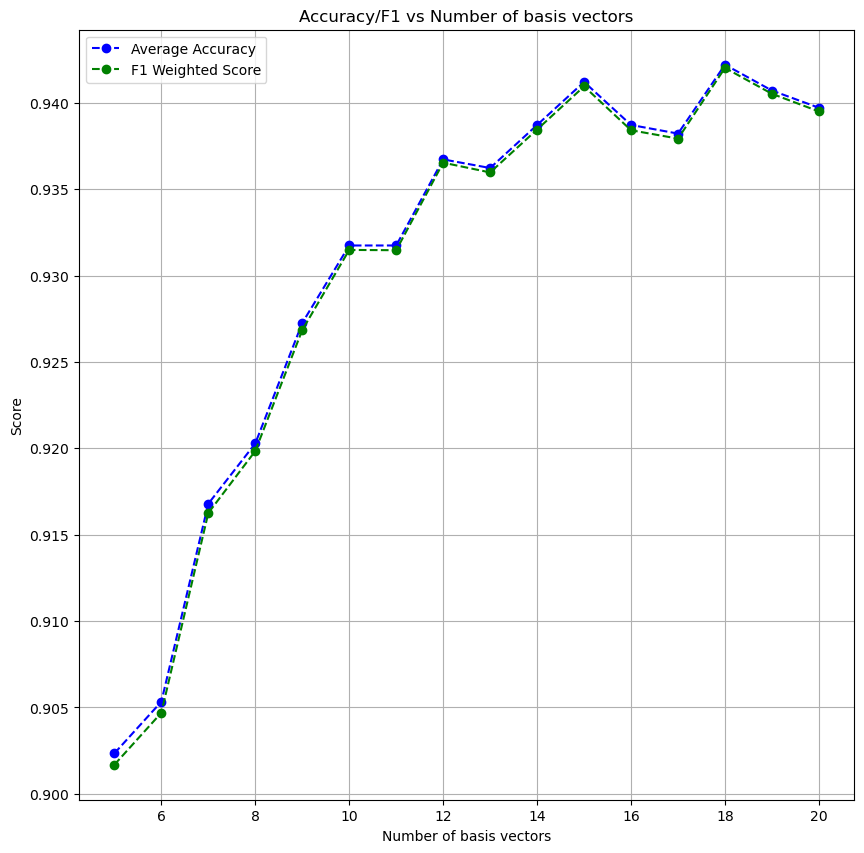

In [33]:
### Plot It
plt.figure(figsize=(10,10))
plt.grid()
plt.plot(np.arange(5,21), accuracies, 'bo--', label="Average Accuracy")
plt.plot(np.arange(5,21), f1_scores, 'go--', label="F1 Weighted Score")
plt.title("Accuracy/F1 vs Number of basis vectors")
plt.xlabel("Number of basis vectors")
plt.ylabel("Score")
plt.legend(loc=2)
plt.savefig("Basis_vectors_GS.png")
plt.show()

### Let's use the best setting (Number of Base Vectors = 18) in terms of Accuracy/F1 Score for the rest of the Exersize

In [34]:
BEST_N_BASE_VEC = 18

### Question 2
***

In [35]:
### Let's See what is misclassified
predictions = [classify_by_residual(f.T, groups, k=BEST_N_BASE_VEC) for f in x_t.T]
real = np.squeeze(y_t)
result_array = confusion_matrix(real,predictions)

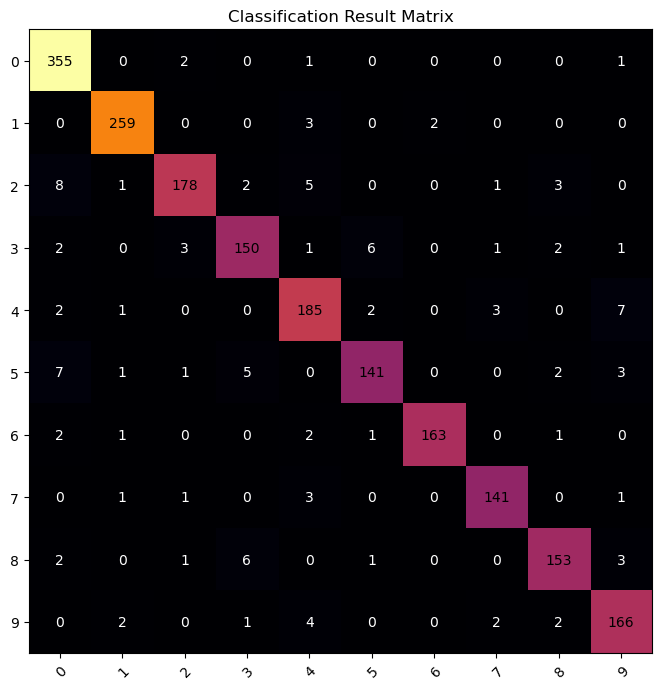

In [36]:
heatmap(result_array)

Digit 0 has 4 misclassifications resulting in 1.114% of misclassification rate. Here are 4 of them:



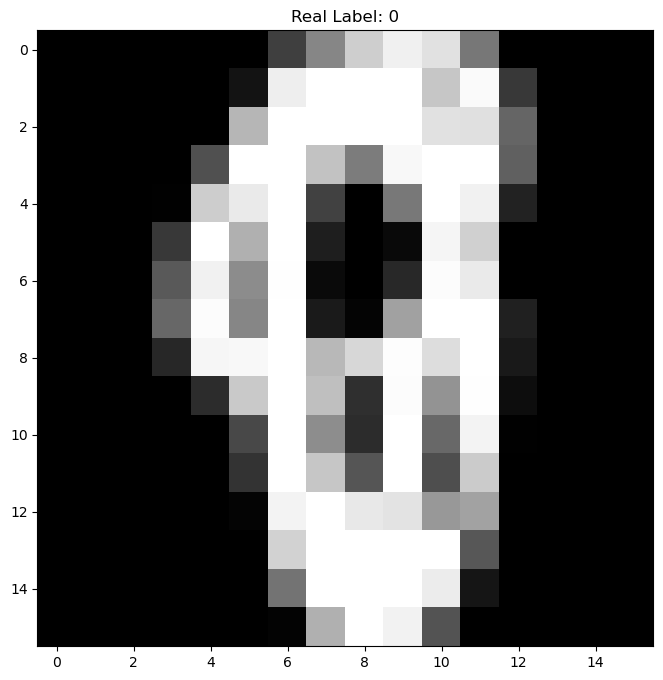

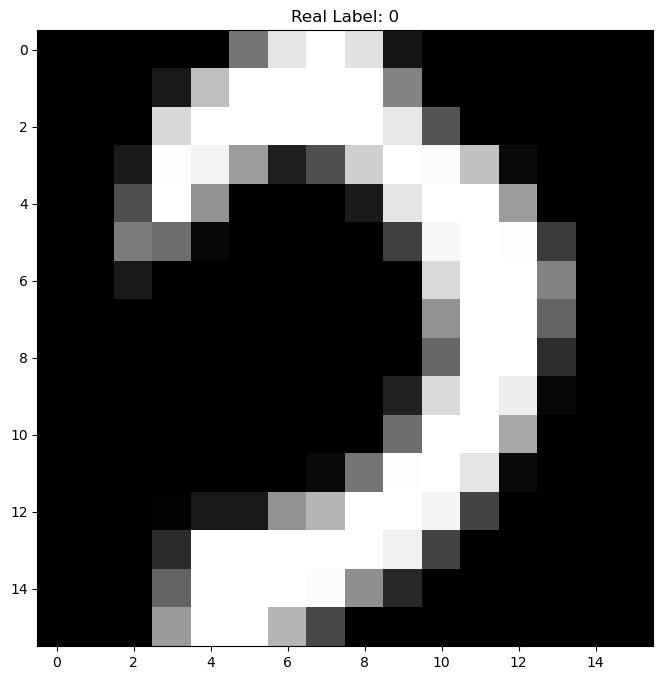

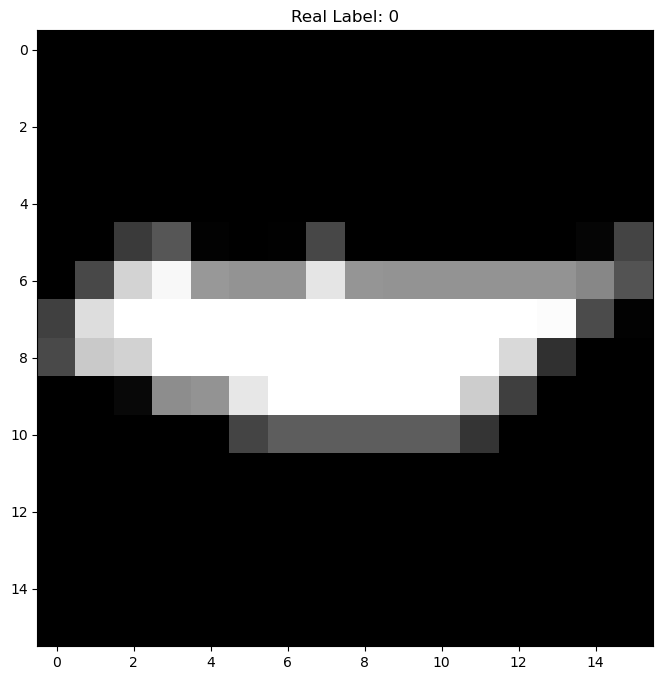

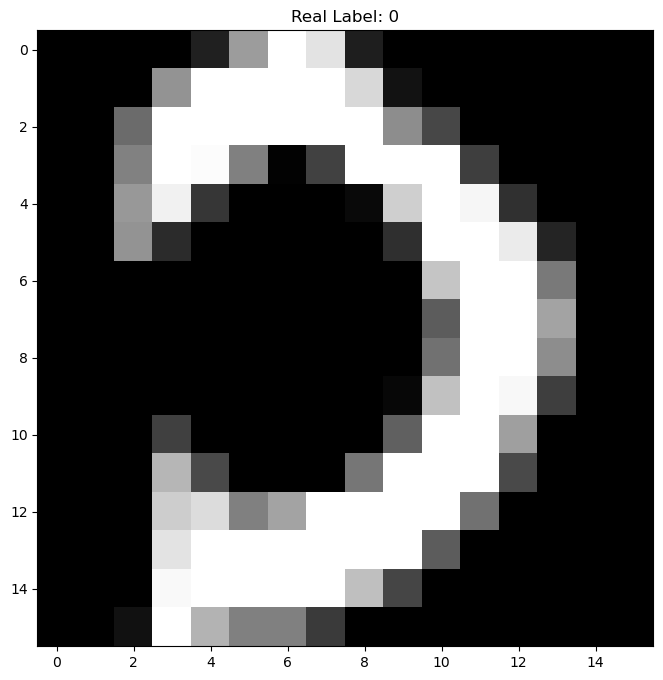

--------------------------------------------------------------

Digit 1 has 5 misclassifications resulting in 1.894% of misclassification rate. Here are 4 of them:



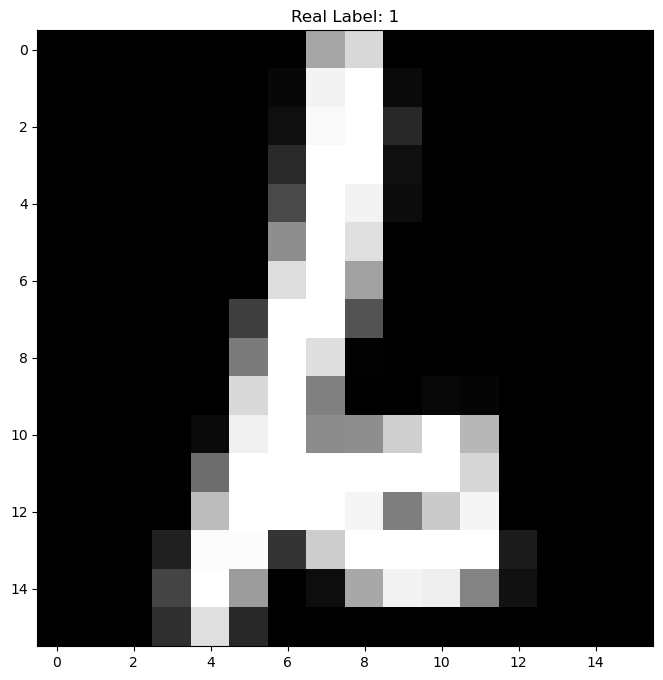

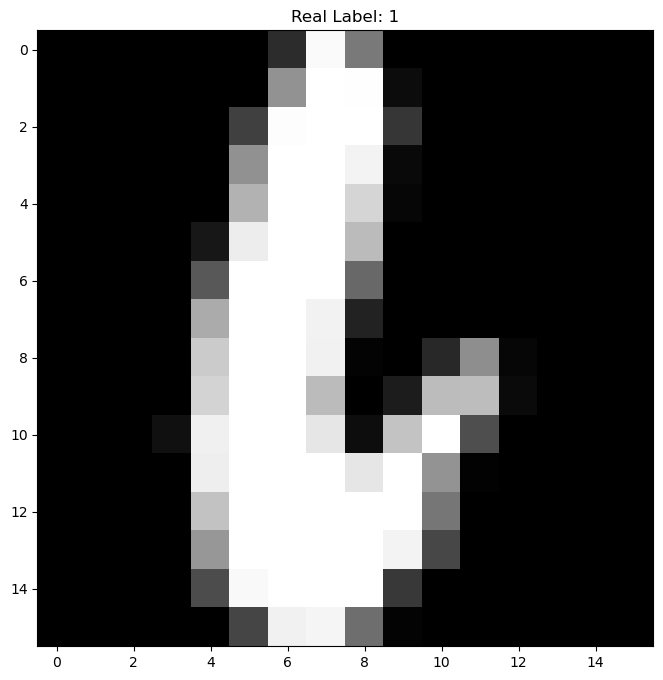

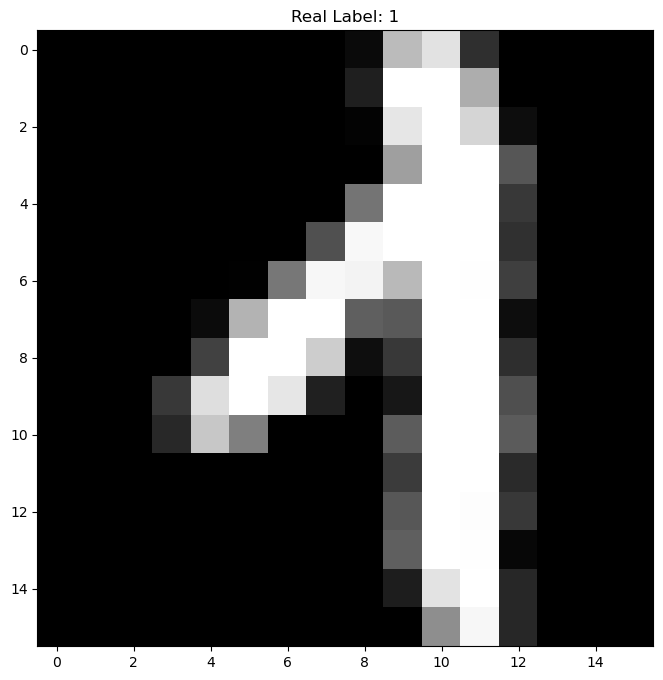

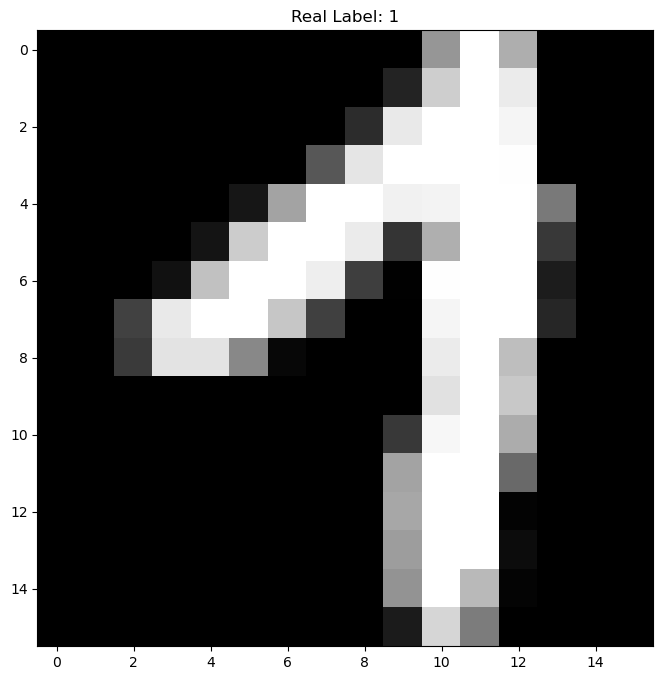

--------------------------------------------------------------

Digit 2 has 20 misclassifications resulting in 10.101% of misclassification rate. Here are 4 of them:



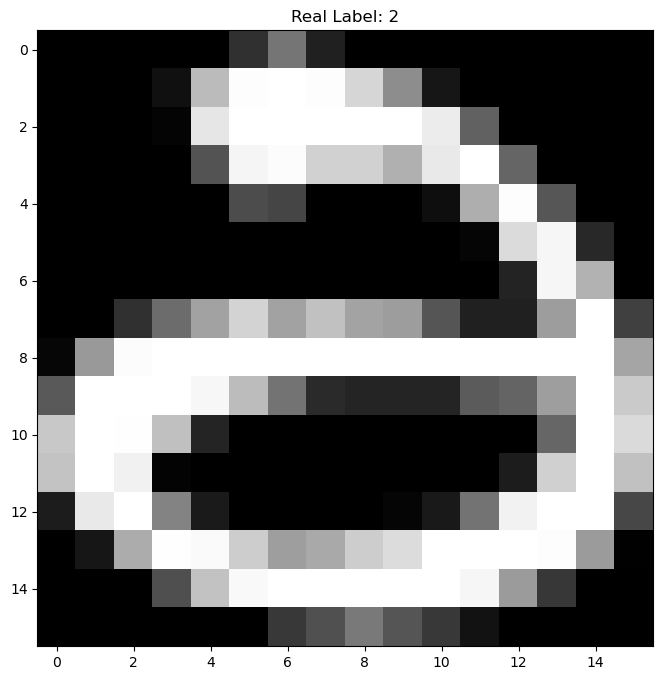

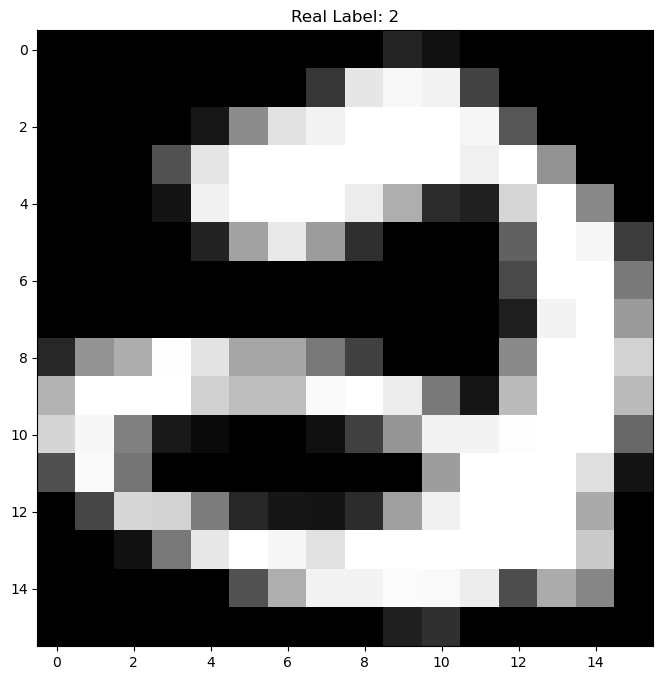

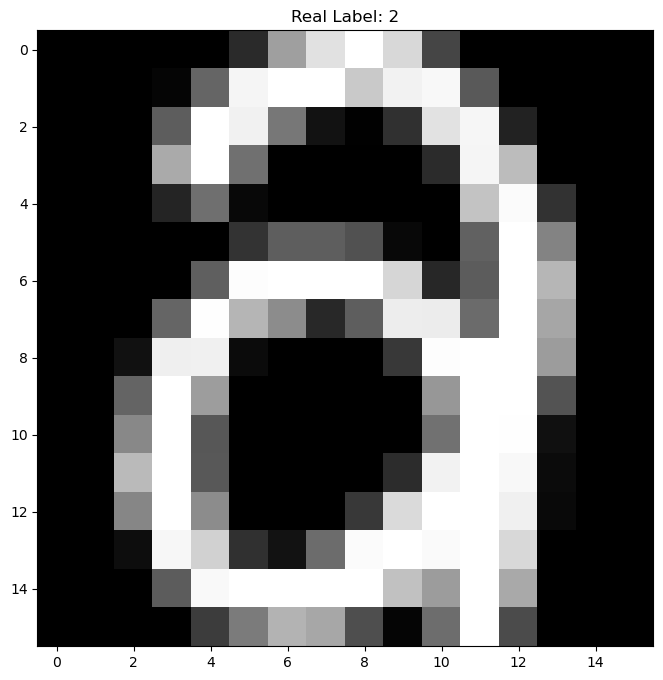

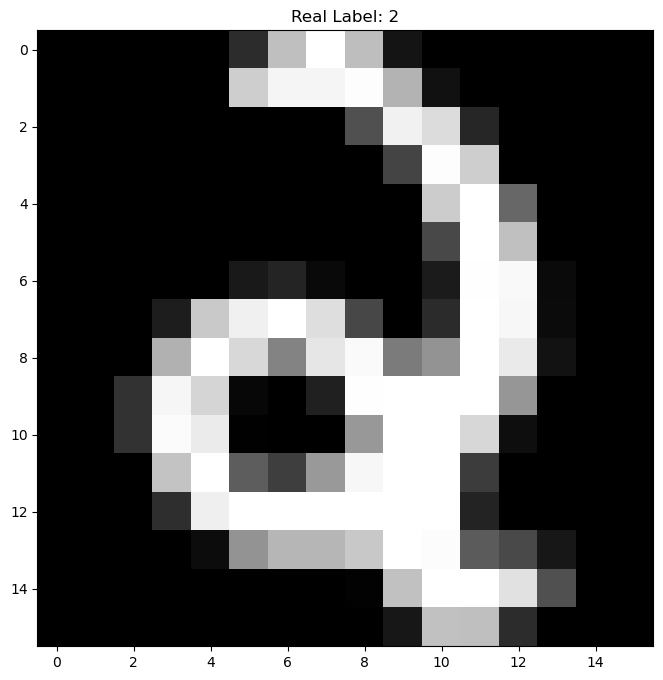

--------------------------------------------------------------

Digit 3 has 16 misclassifications resulting in 9.639% of misclassification rate. Here are 4 of them:



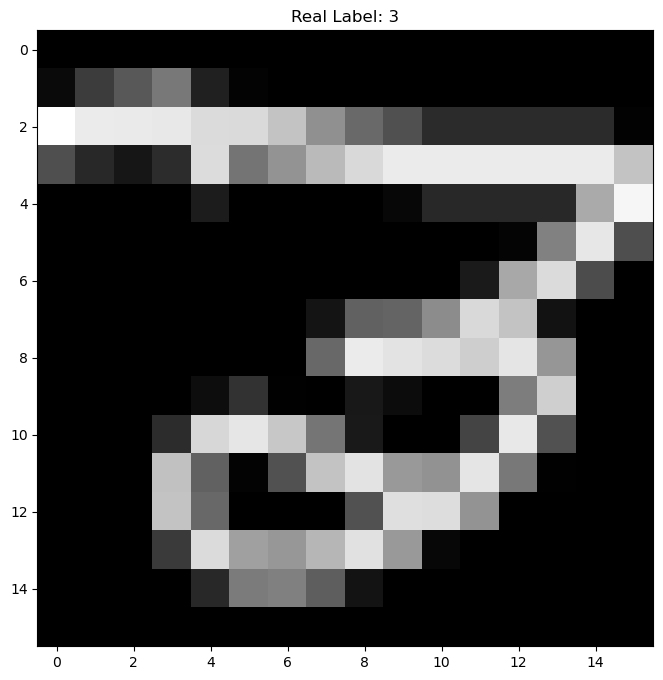

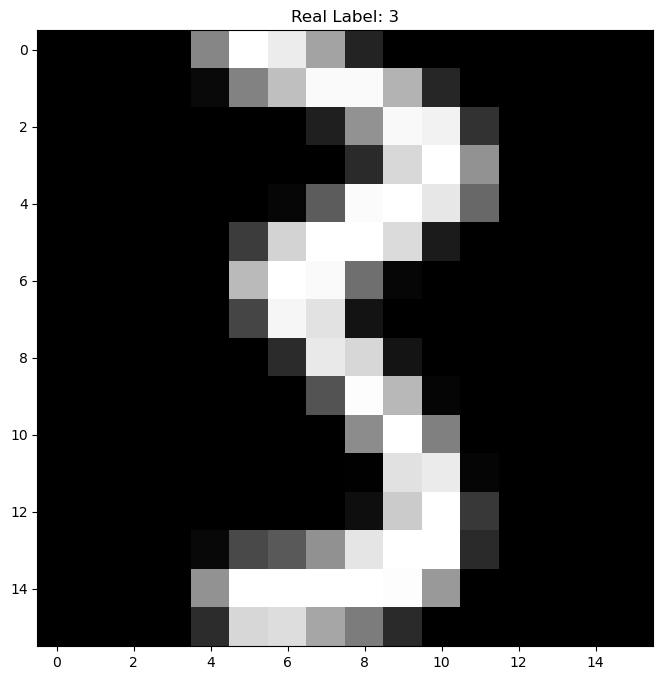

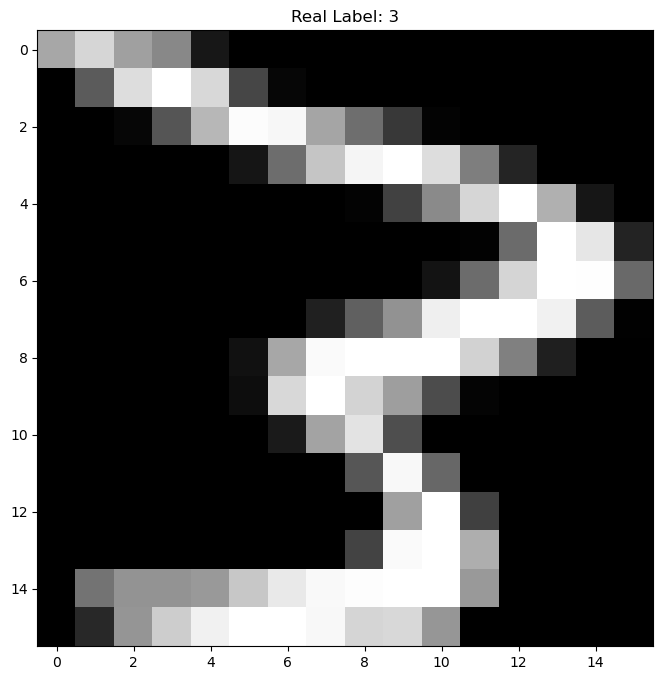

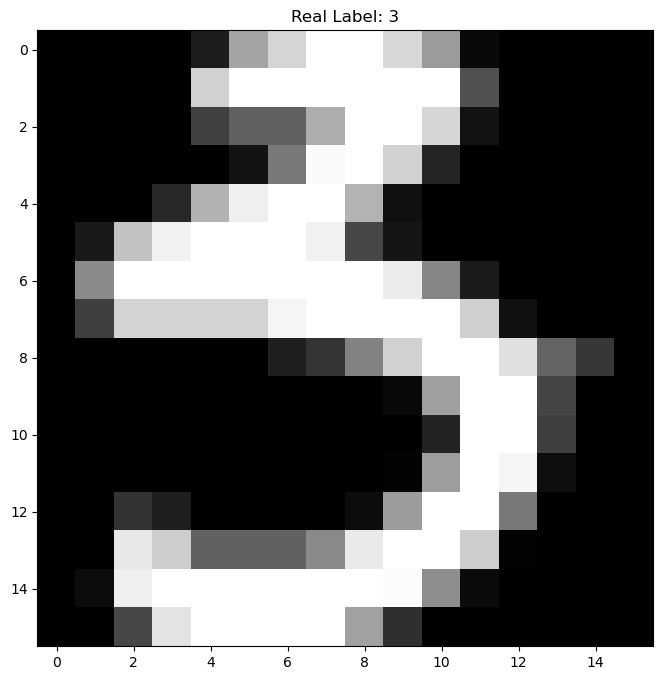

--------------------------------------------------------------

Digit 4 has 15 misclassifications resulting in 7.5% of misclassification rate. Here are 4 of them:



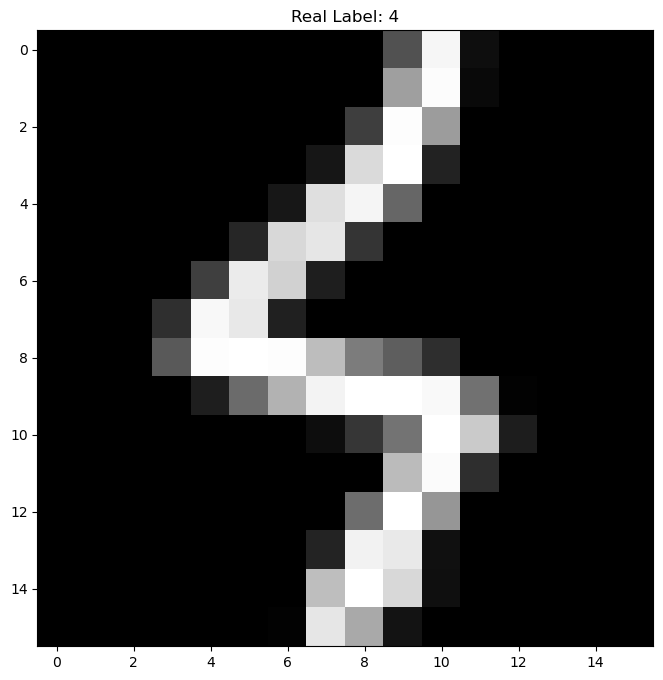

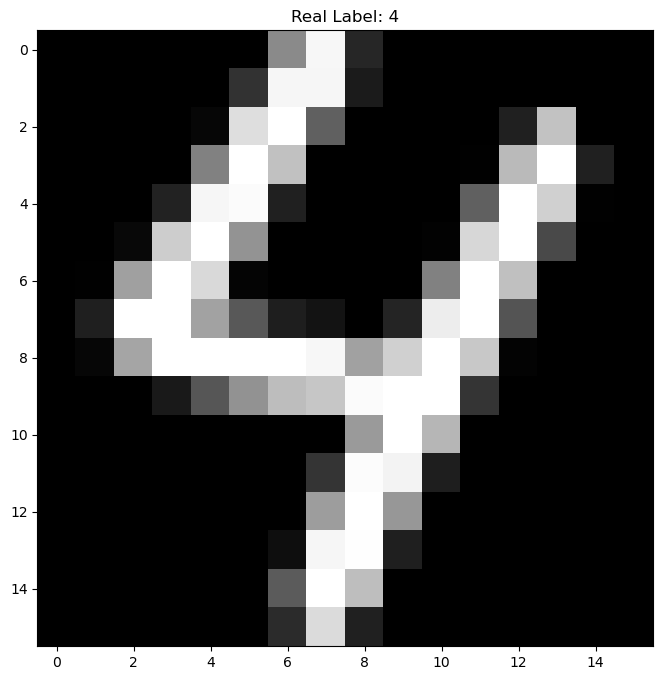

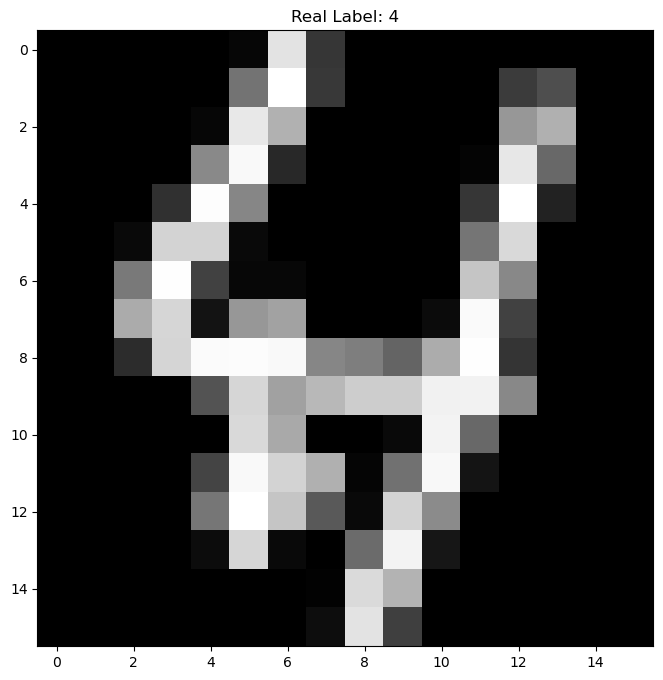

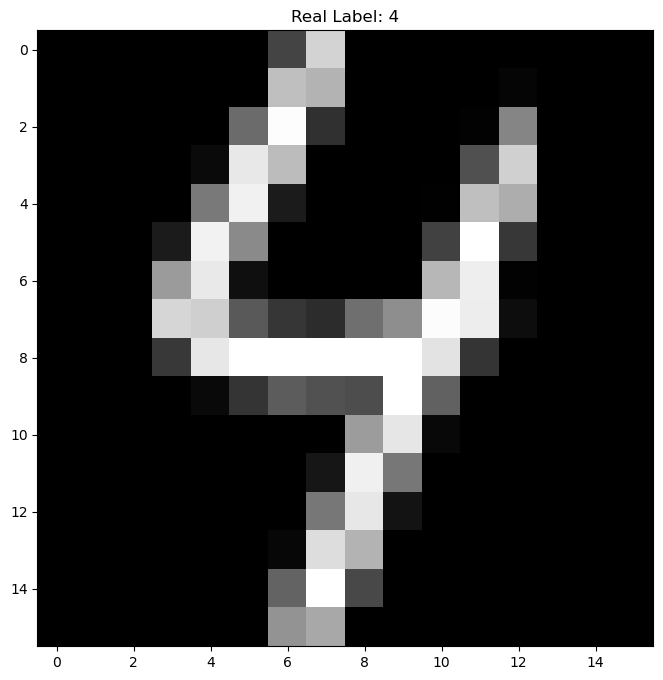

--------------------------------------------------------------

Digit 5 has 19 misclassifications resulting in 11.875% of misclassification rate. Here are 4 of them:



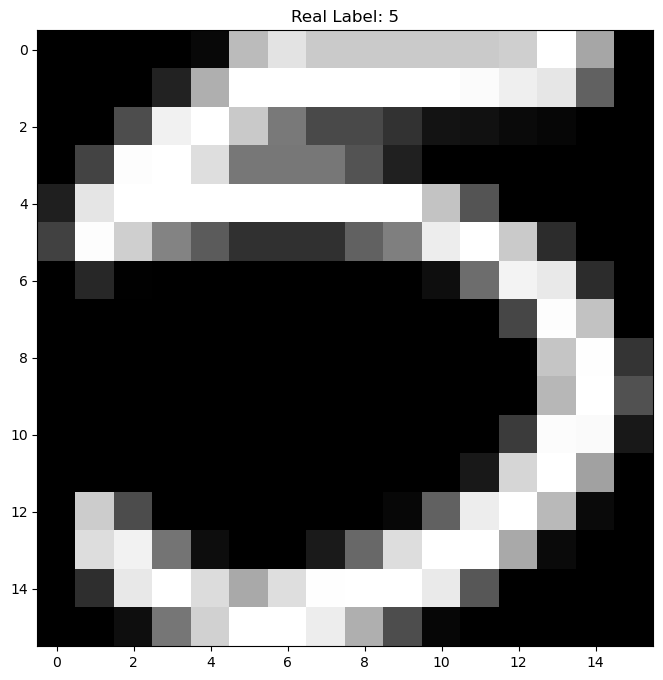

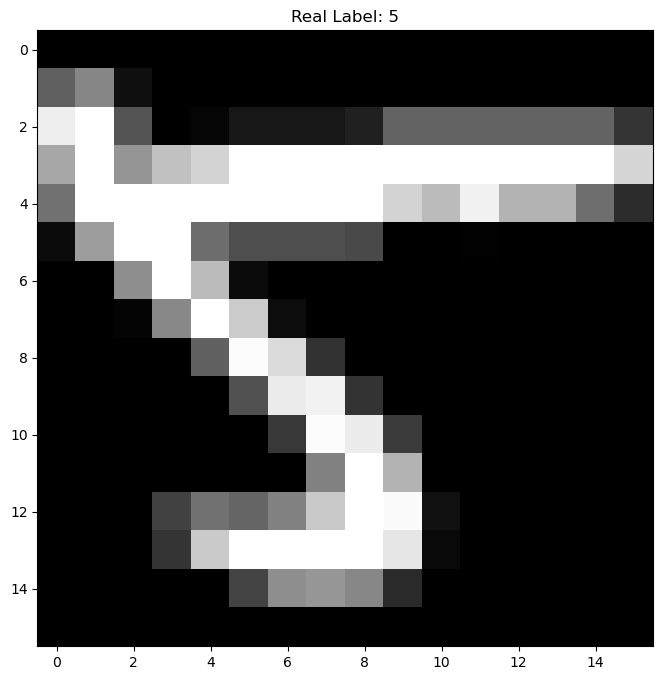

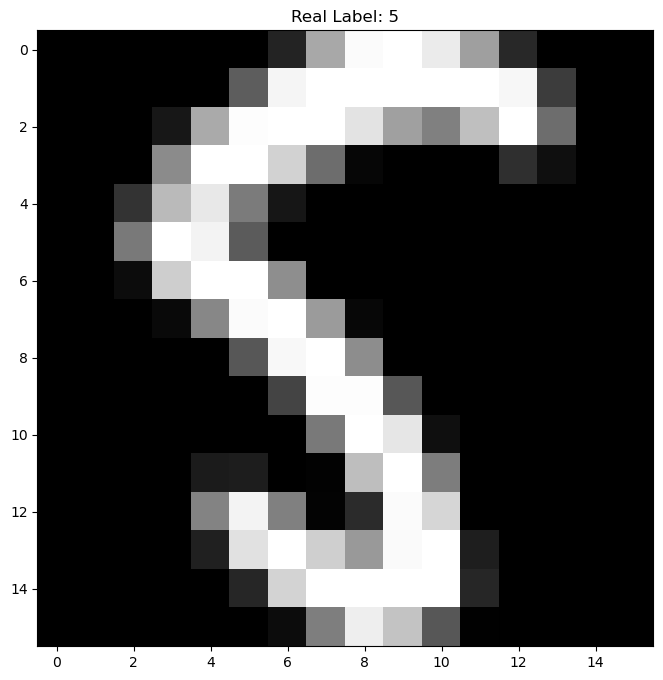

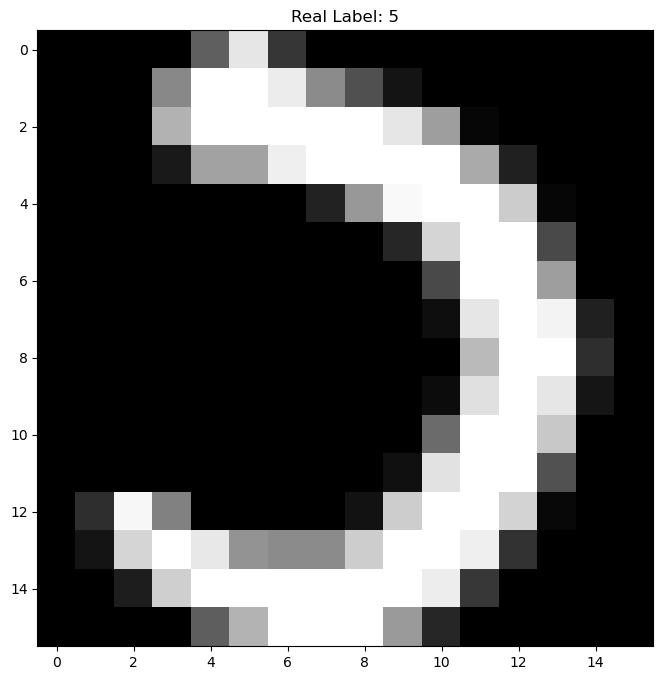

--------------------------------------------------------------

Digit 6 has 7 misclassifications resulting in 4.118% of misclassification rate. Here are 4 of them:



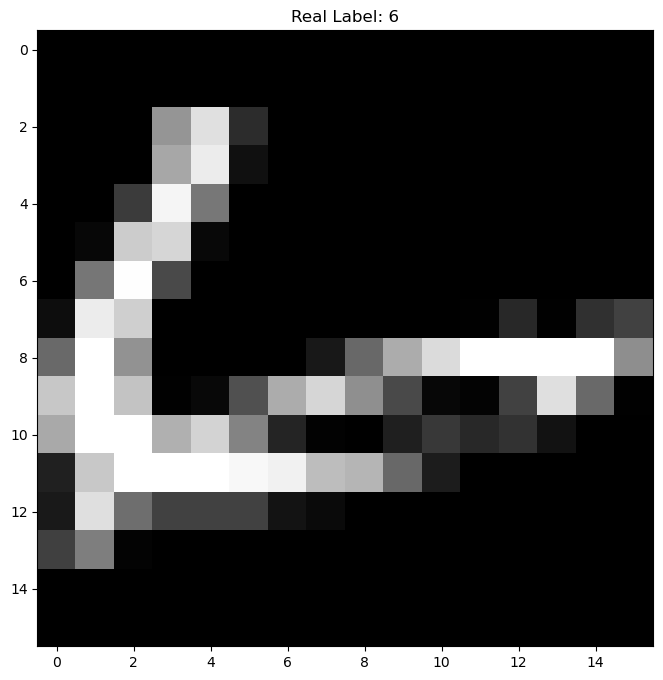

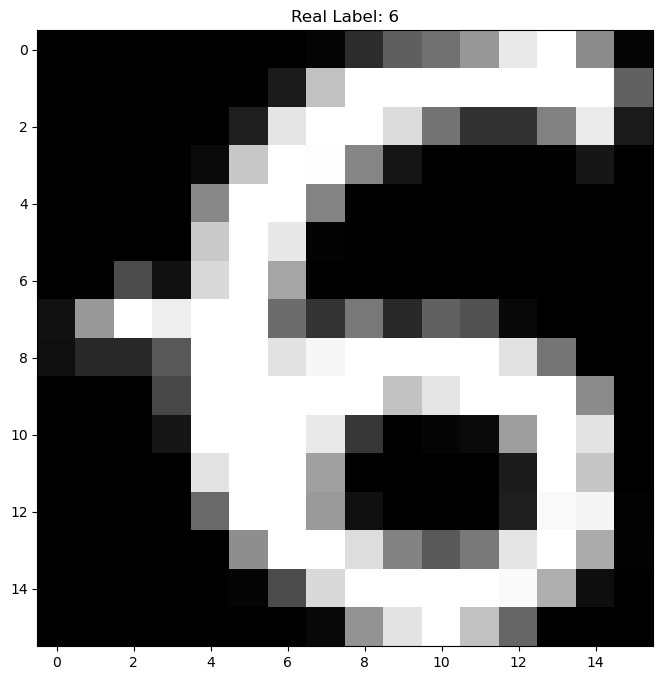

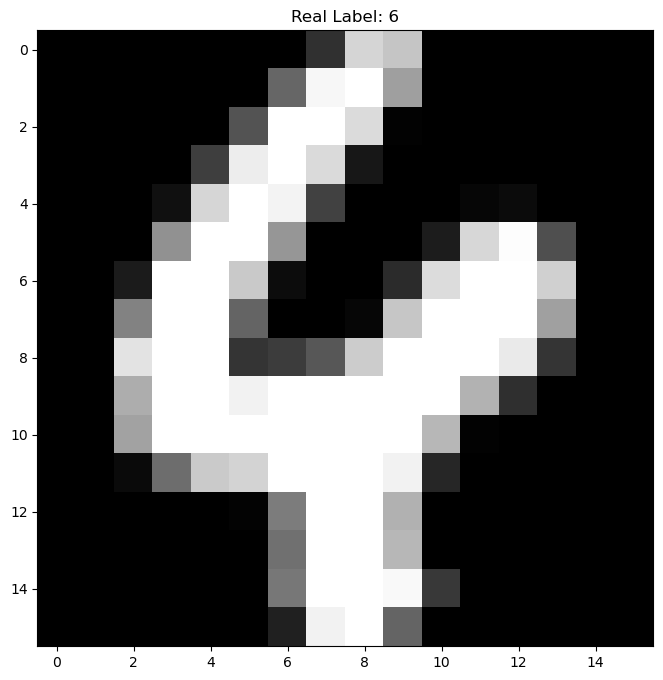

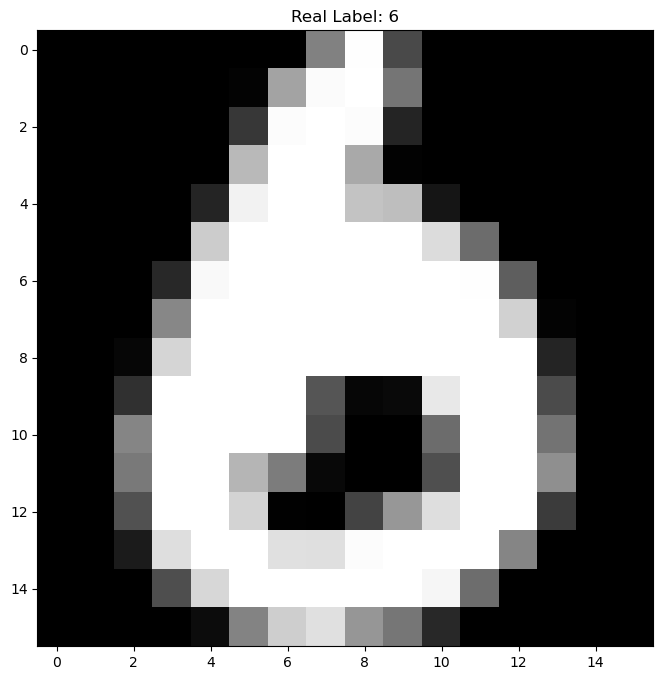

--------------------------------------------------------------

Digit 7 has 6 misclassifications resulting in 4.082% of misclassification rate. Here are 4 of them:



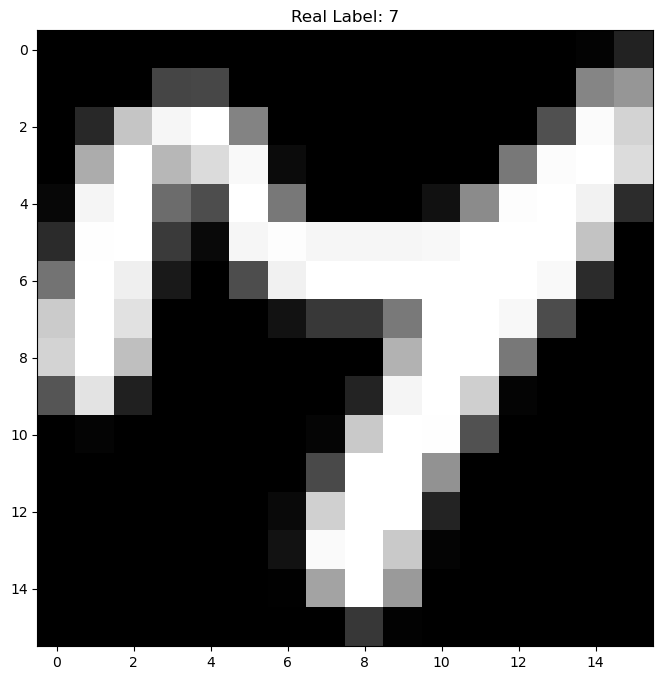

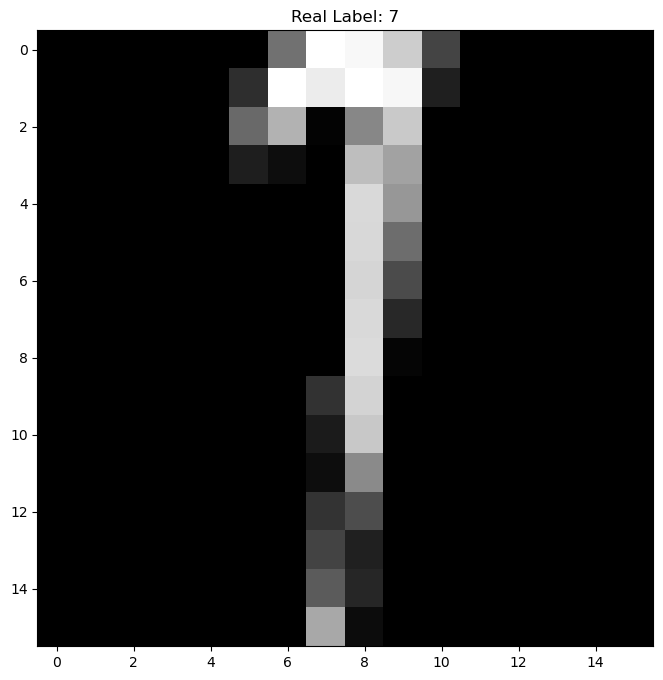

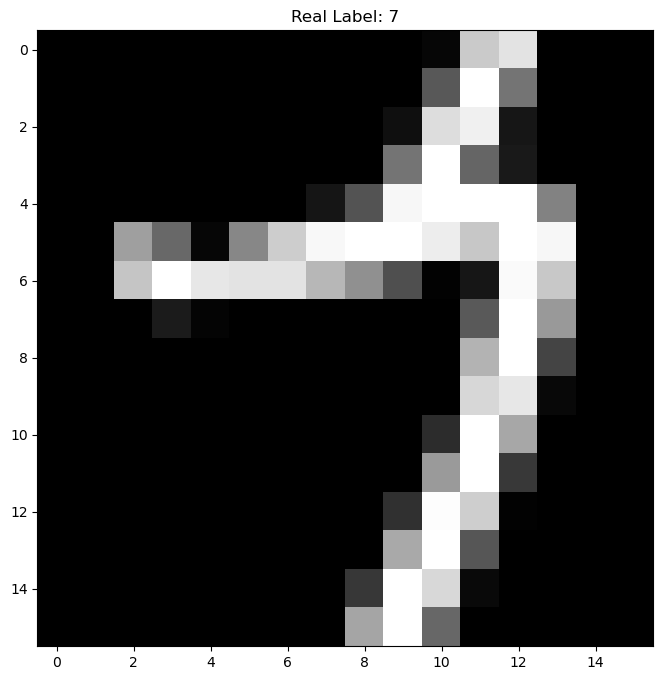

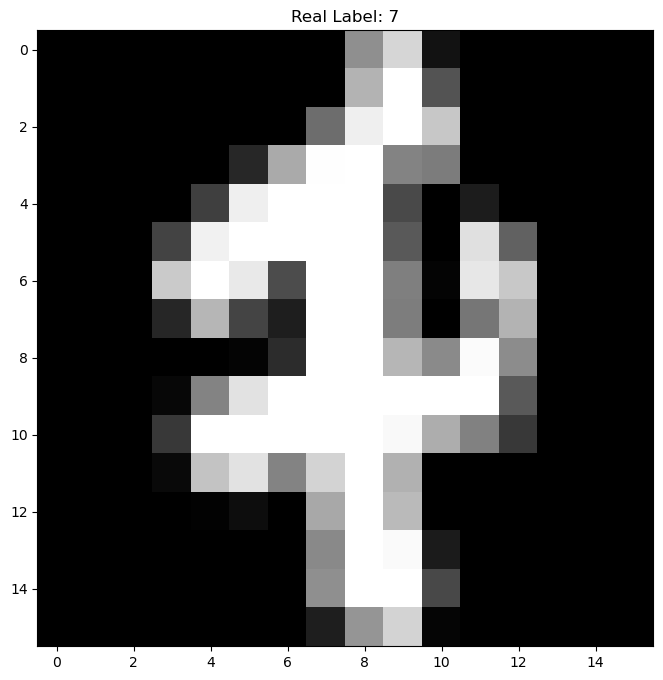

--------------------------------------------------------------

Digit 8 has 13 misclassifications resulting in 7.831% of misclassification rate. Here are 4 of them:



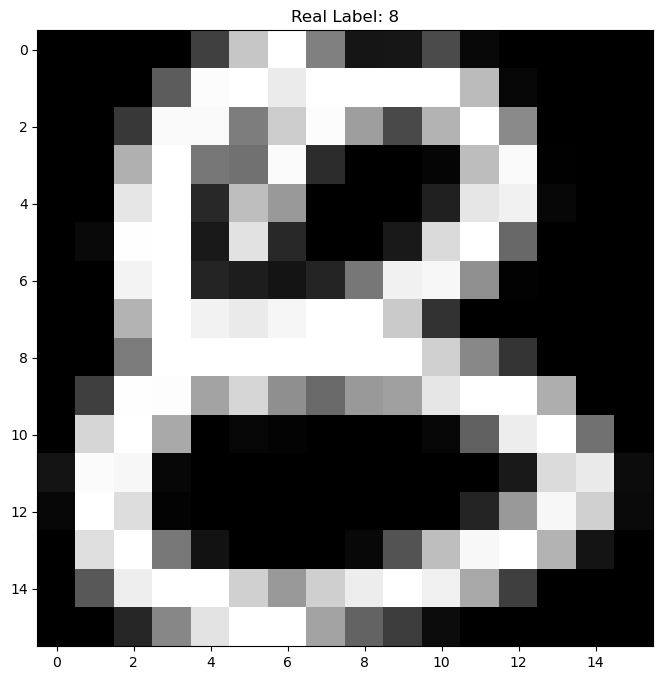

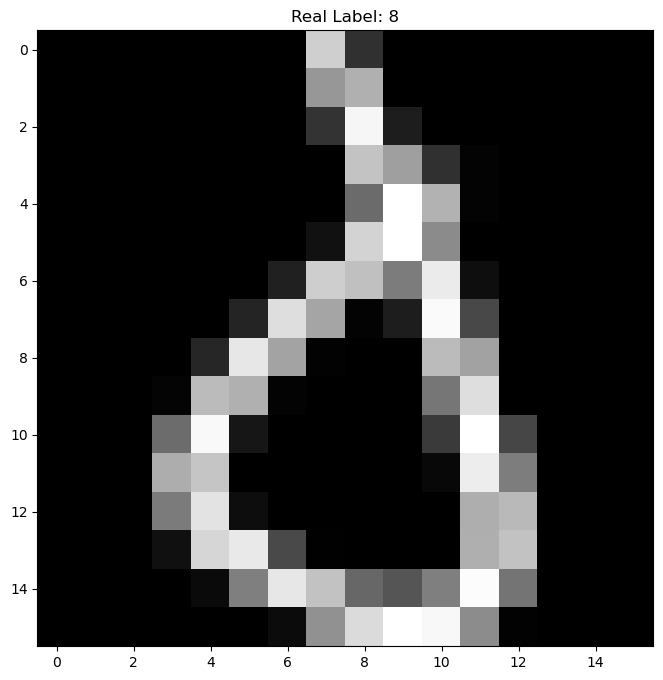

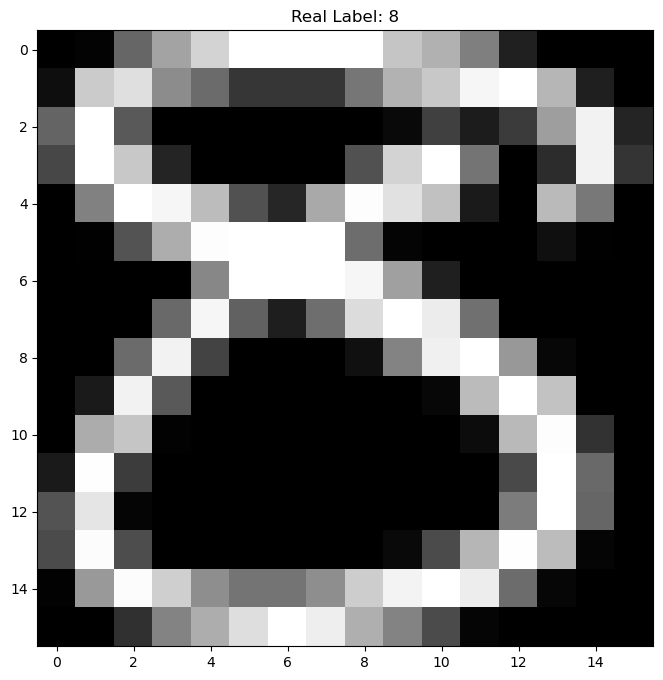

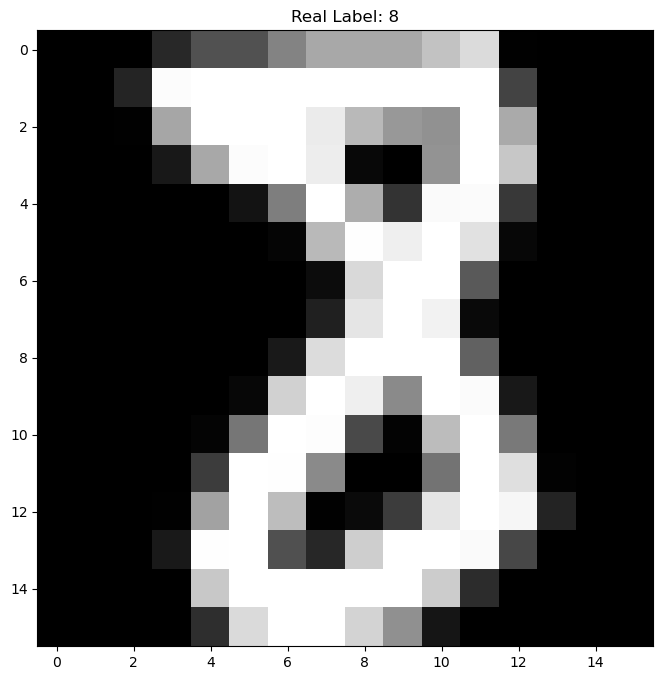

--------------------------------------------------------------

Digit 9 has 11 misclassifications resulting in 6.215% of misclassification rate. Here are 4 of them:



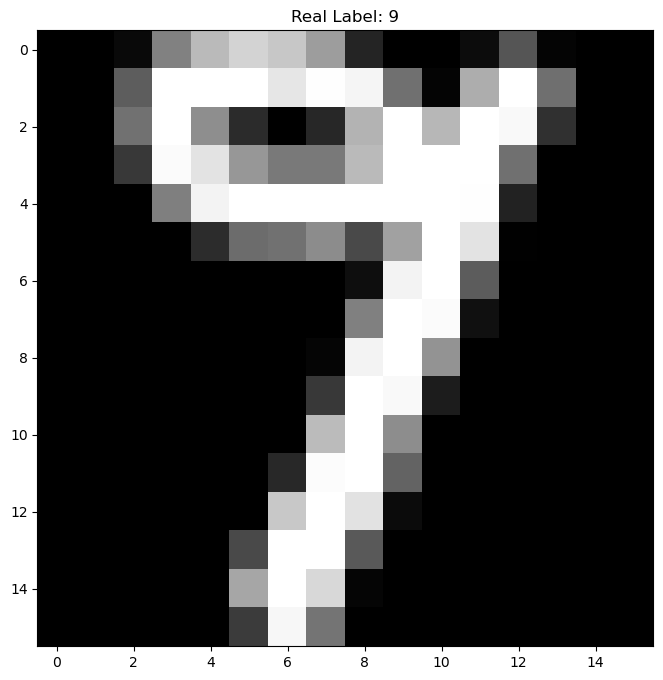

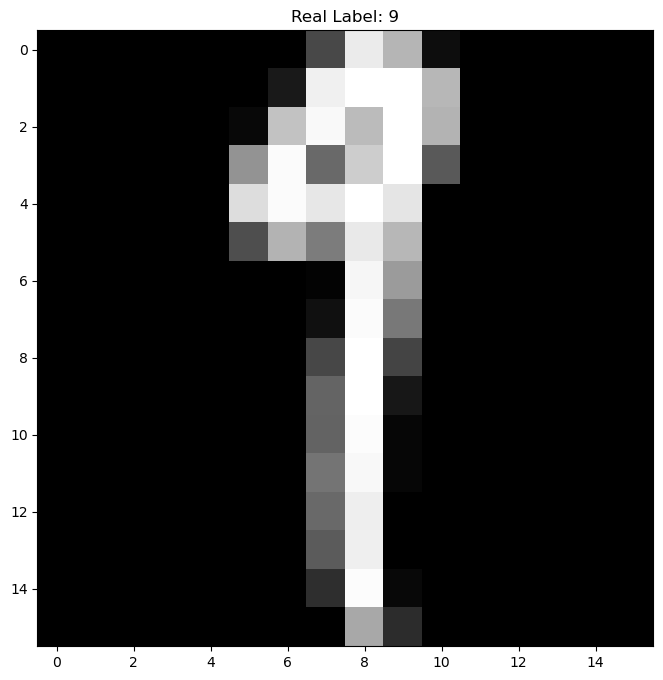

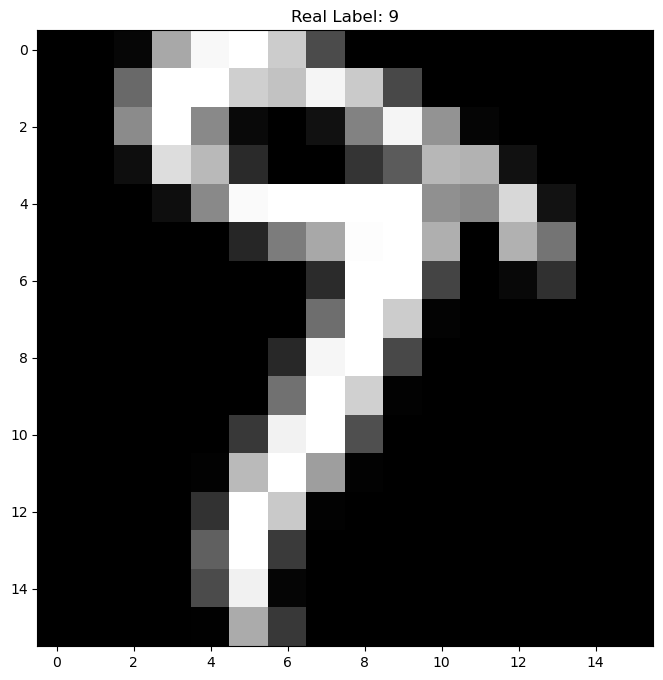

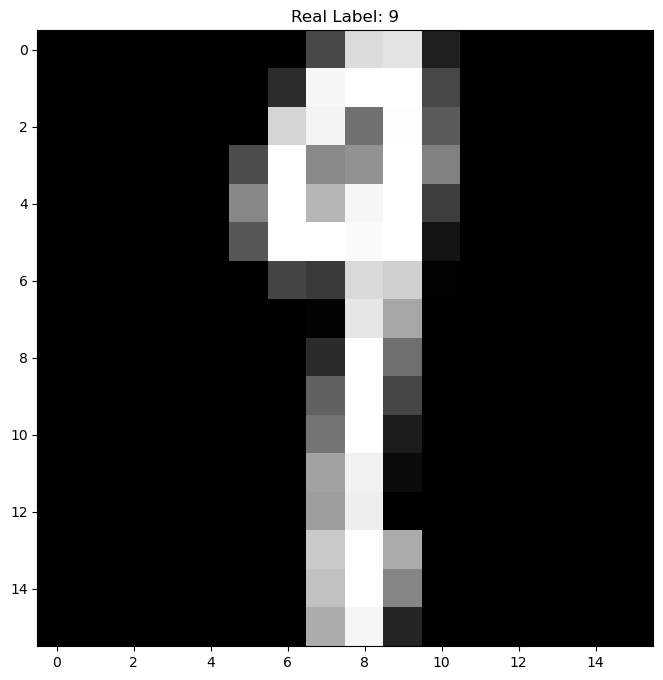

--------------------------------------------------------------



In [37]:
misclassification_analysis(x_t,y_t,groups)

### Question 3
***

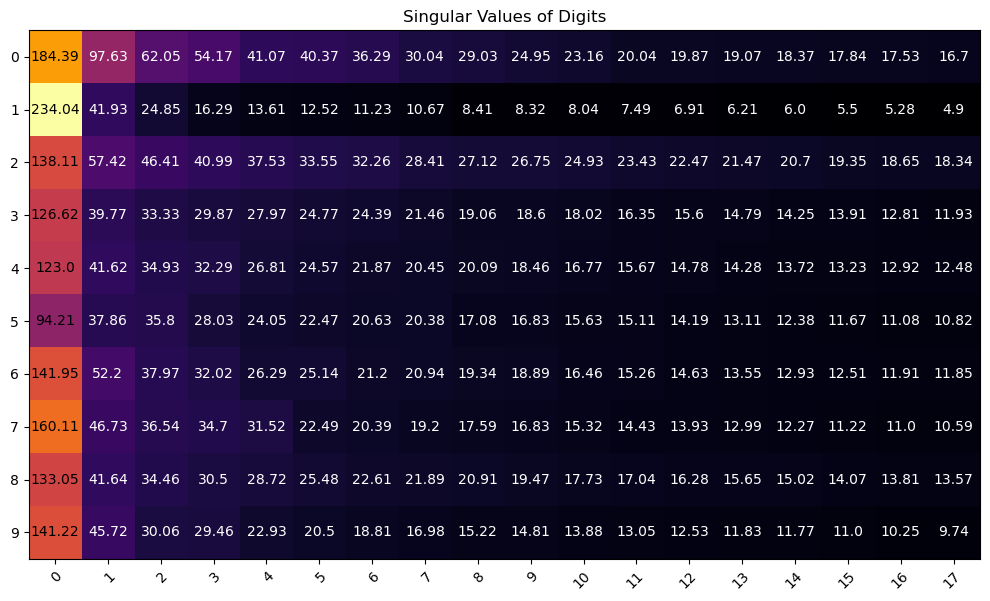

In [38]:
### Let's plot the first 18 signular values for our 10 digits.
singular_value_search(groups)

### As we can see in class 0 and in class 1 the first signular values exceed greatly the following ones. That means that the majority of the compression information is included mostly there. For our next experiment we will focus on class 0 and 1 and perform a grid search on the number of singular vectors used versus the accurary of the predictions in those digits.

The top 18 singular Values of 0 are: 184.39 97.63 62.05 54.17 41.07 40.37 36.29 30.04 29.03 24.95 23.16 20.04 19.87 19.07 18.37 17.84 17.53 16.7



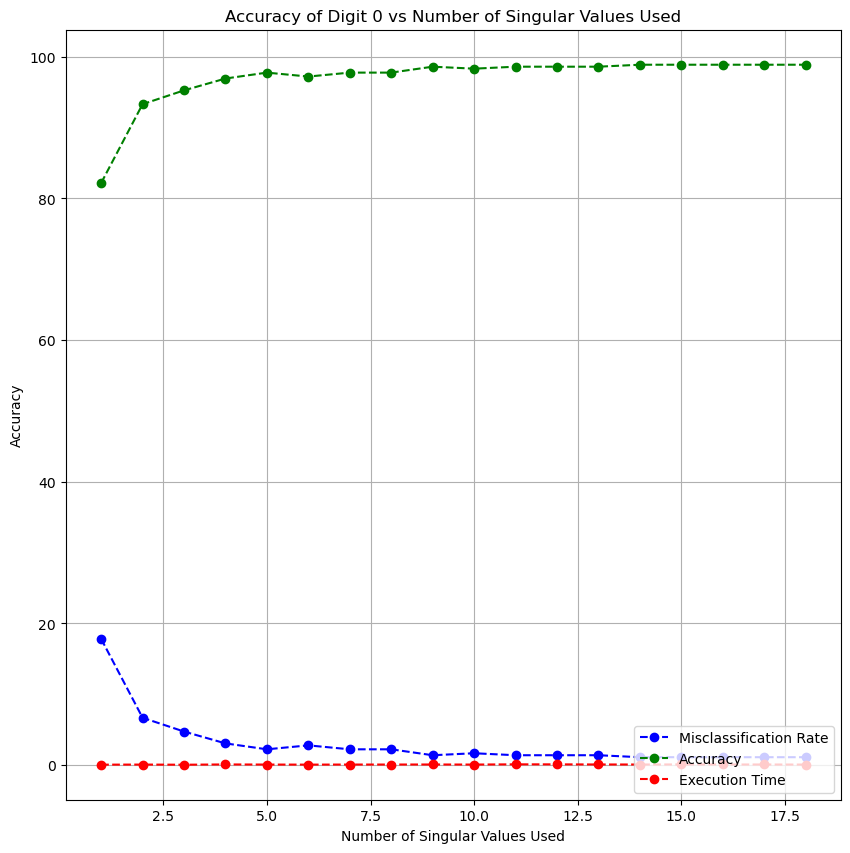

The top 18 singular Values of 1 are: 234.04 41.93 24.85 16.29 13.61 12.52 11.23 10.67 8.41 8.32 8.04 7.49 6.91 6.21 6.0 5.5 5.28 4.9



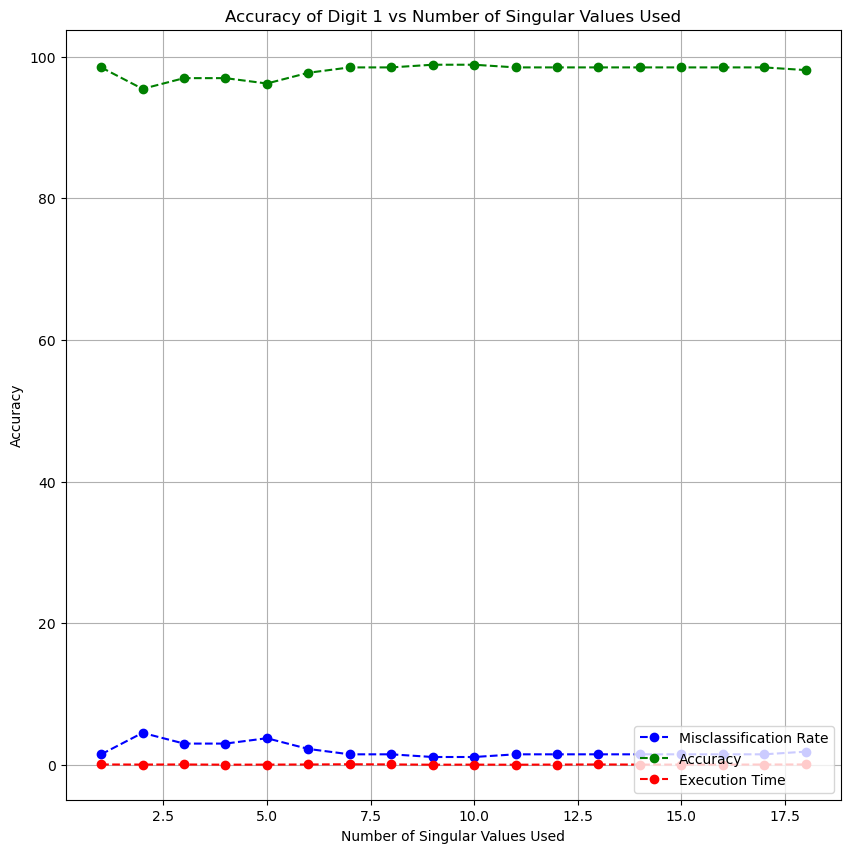

In [39]:
for f in [0,1]:
    print(f"The top 18 singular Values of {f} are: {' '.join(map(lambda x: str(round(x,2)), groups[f]['s'][0:18]))}\n")
    singular_value_performance(x_t,y_t,groups,f)

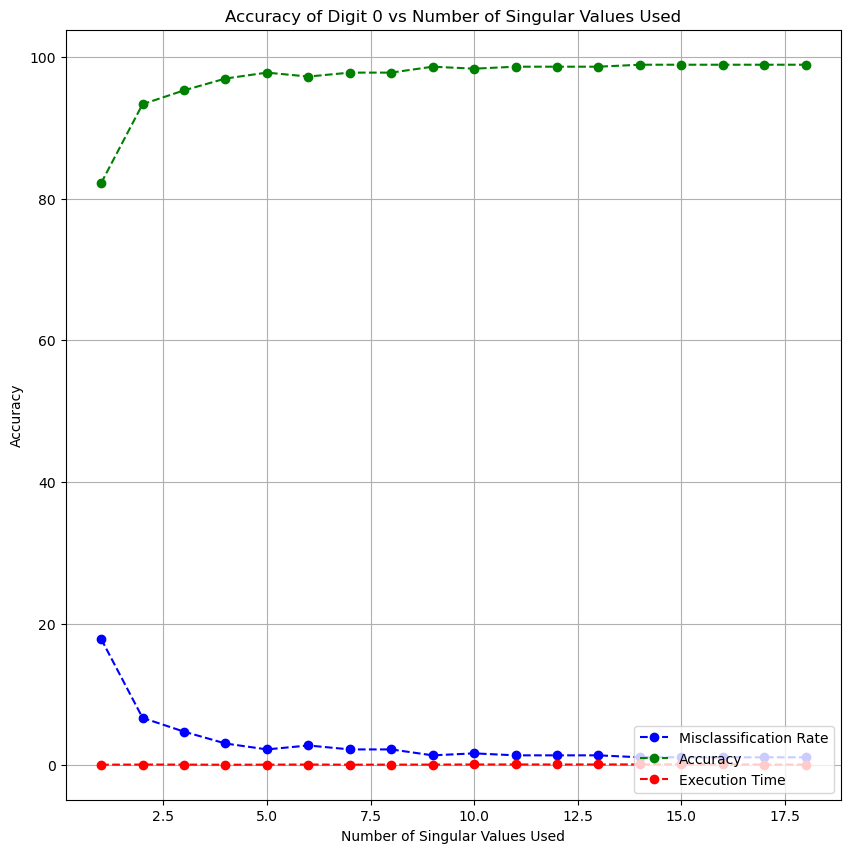

In [56]:
singular_value_performance(x_t,y_t,groups,0)

### For digit 0 we can see that using 4 or more singular values is a good tradeoff between accuracy and complexity in operations, whereas for digit 1 using only the first singular value is enough. 

### Optional Question 1
***

### As a measure of whether to predict using 1 or more singular values we choose to measure the relative difference between the smallest and the second smallest residual error.
### If that difference does not exceed a user defined percentage named tol, we proceed with using 18 singular values. Else only 1 signular value is used.
### The function two_step_classify that threshold analysis implements returns the prediction as well as a flag that indicates whether 18 values were used (0) or only one (1).

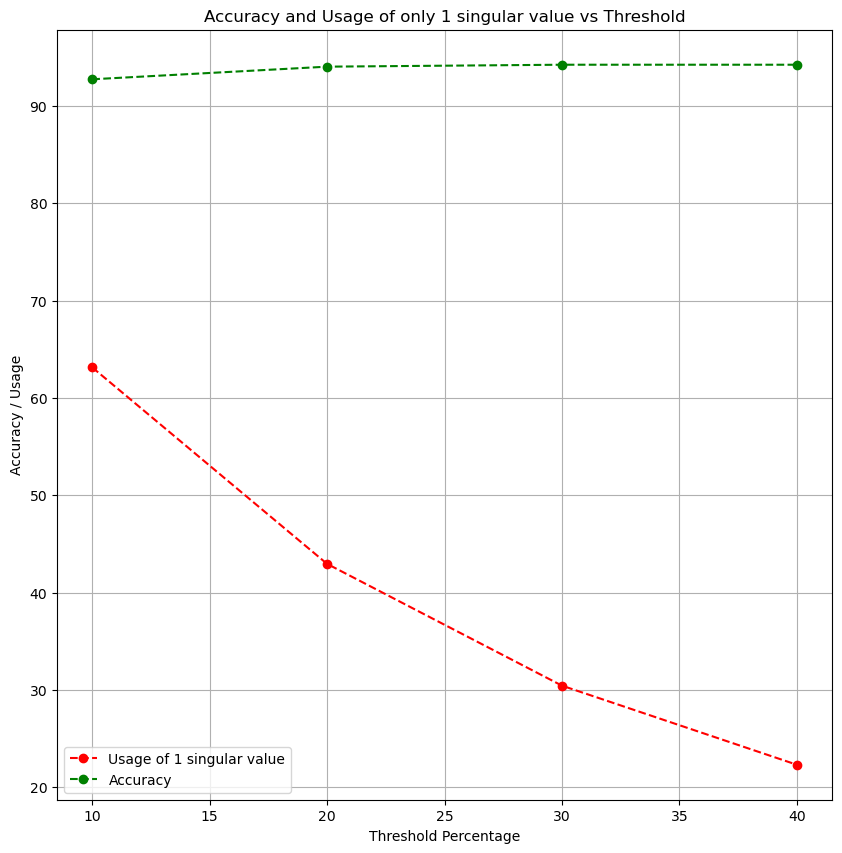

In [40]:
threshold_analysis(x_t,y_t,groups)